<a href="https://colab.research.google.com/github/jmamath/Bottom-Sea-Detection/blob/master/VAE/train_VAE_RNN_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade tensorflow
!pip install tensorflow_probability==0.8.0rc0 --user --upgrade

     |████████████████████████████████| 86.3MB 39kB/s 
     |████████████████████████████████| 450kB 62.2MB/s 
     |████████████████████████████████| 3.8MB 45.8MB/s 
     |████████████████████████████████| 81kB 12.0MB/s 
ERROR: tensorboard 2.0.1 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.1 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalle

     |████████████████████████████████| 2.5MB 2.8MB/s 
ERROR: tensor2tensor 1.14.1 has requirement tensorflow-probability==0.7.0, but you'll have tensorflow-probability 0.8.0rc0 which is incompatible.
ERROR: gym 0.15.4 has requirement cloudpickle~=1.2.0, but you'll have cloudpickle 1.1.1 which is incompatible.


In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
print(tf.__version__)
print(tfp.__version__)

1.15.0
0.7.0


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GRU, Dense, Input, Bidirectional, Lambda, Masking, Concatenate, RepeatVector
from tensorflow.keras.models import  Model, load_model
import tensorflow.keras.backend as K
import time

print("TensorFlow executing eagerly: {}".format(tf.executing_eagerly()))

In [0]:
from tensorflow.keras import activations
from tensorflow.keras import initializers
from tensorflow.keras.layers import Layer, Concatenate, Lambda, InputSpec
import tensorflow as tf
import tensorflow.keras.backend as K

import tensorflow_probability as tfp
tfd = tfp.distributions

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, batch_size, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.data = data            
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        batch = self.data[indexes]

        # Generate data
        augmented = self.data_augmentation(batch)
#        import pdb; pdb.set_trace()
        global_input_output, decoder_input = self.get_training_data(augmented)          
        return global_input_output,decoder_input          
    
    def get_training_data(self,data_offset):
        """
        Note that encoder_input = decoder_output:
          (S1, S2, ..., Sn, 0, ..., 0)
          So we label it global_input_output
        But decoder_input is of the form:
          (S0, S1, ..., Sn-1, 0, ..., 0)
        So we are going to label the first sequence encoder input, and
        the latter decoder input
        Args: 
          data_offset: tensor of size (batch_size, timestep+1, input_dim)
        Return:
          input_output: tensor of size (batch_size, timestep+1, input_dim)
          decoder_input: tensor of size (batch_size, timestep+1, input_dim)
        """        
        decoder_input = data_offset[:,:-1,:]
        global_input_output = data_offset[:,1:,:]
        return global_input_output, decoder_input

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.data))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def data_augmentation(self, data):
        """
        Online data augmentation: we multiply each set of coordinates 
        (x,y) by a uniform random factor
        
        Args:
            offsets: Numpy object of shape (num_sample, timesteps, 5)        
        Return:
            augmented offset        
        """
        random_factor = np.random.uniform(low=.9, high=1.1, size=2).astype(np.float32)
        ones = np.ones(3, dtype=np.float32)
        factor = np.concatenate([random_factor,ones])      
        return data * factor

class GMM(Layer):    
    """
    Gaussian Mixture Model: 
    
    # Arguments
        k_mixture: Positive integer, number of mixture component.
        output_dim: Positive integer, dimensionality of generated output in our case it's equal to 3
        (x,y,eos) 2 dimensions for the position of a point, and the last dimension is for the end of stroke probability
        kernel_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
    
    """
    def __init__(self, 
                 k_mixture,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 debugging=False,                 
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(GMM, self).__init__(**kwargs)
        self.output_dim = 3
        self.debugging=debugging      
        self.k_mixture = k_mixture        
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer=initializers.get(bias_initializer)
        self.input_spec = [InputSpec(min_ndim=self.output_dim),InputSpec(min_ndim=self.output_dim)]
        
#    def compute_mask(self, inputs, mask=None):   
#        # do not pass the mask to the next layers   
#        return None  

    def build(self, input_shape):
        input_dim = int(input_shape[0][-1])
    
        # Alpha
        self.alpha_kernel = self.add_weight(shape=[input_dim,self.k_mixture],
                                       initializer=self.kernel_initializer,
                                       name='alpha_kernel')
        self.alpha_bias = self.add_weight(shape=(1,self.k_mixture),
                                     initializer=self.bias_initializer,
                                     name='alpha_bias')
        # Sigma
        self.sigma_kernel = self.add_weight(shape=(input_dim,2*self.k_mixture),
                                       initializer=self.kernel_initializer,
                                       name='sigma_kernel')
        self.sigma_bias = self.add_weight(shape=(1,2*self.k_mixture),
                                     initializer=self.bias_initializer,
                                     name='sigma_bias')
        # Mu
        self.mu_kernel = self.add_weight(shape=(input_dim,2*self.k_mixture),
                                       initializer=self.kernel_initializer,
                                       name='mu_kernel')
        self.mu_bias = self.add_weight(shape=(1,2*self.k_mixture),
                                     initializer=self.bias_initializer,
                                     name='mu_bias') 
        # Rho
#        self.rho_kernel = self.add_weight(shape=(input_dim,self.k_mixture),
#                                       initializer=self.kernel_initializer,
#                                       name='rho_kernel')
#        self.rho_bias = self.add_weight(shape=(1,self.k_mixture),
#                                     initializer=self.bias_initializer,
#                                     name='rho_bias') 

        # End of stroke probability eos = (p1,p2,p3)
        self.eos_kernel = self.add_weight(shape=(input_dim,3),
                                       initializer=self.kernel_initializer,
                                       name='end_of_stroke_kernel')
        self.eos_bias = self.add_weight(shape=(1,3),
                                     initializer=self.bias_initializer,
                                     name='end_of_stroke_bias') 
        
#        self.input_spec = [InputSpec(min_ndim=3, axes={-1: self.output_dim}),InputSpec(min_ndim=3, axes={-1: self.output_dim})]                                    
        super(GMM, self).build(input_shape)  # Be sure to call this at the end    
   
    def call(self, inputs):
        hidden_layer, y = inputs
        # Get the mask to help us when computing probability density function and losses   
        mask = hidden_layer._keras_mask
        mask = K.cast(mask, tf.float32)        
        y_pos = y[:,:,:2]
        y_eos = y[:,:,2:]
        if self.debugging:
            print("                     ------------------                     ")
            print_tensor(mask, "mask")
            print_tensor(y_pos, "y_pos")
            print_tensor(y_eos, "y_eos")             
        batch_size = (K.shape(hidden_layer)[0],)
        timesteps =  K.int_shape(hidden_layer)[1]
        
        # Computing the weights of the GMM
        mu = K.dot(hidden_layer,self.mu_kernel)
        mu = mu + self.mu_bias      
        
        sigma = K.dot(hidden_layer,self.sigma_kernel)
        sigma = sigma + self.sigma_bias
        sigma = K.exp(sigma)
        
        alpha = K.dot(hidden_layer,self.alpha_kernel)
        alpha = alpha + self.alpha_bias
        alpha = K.softmax(alpha)      
        
#        rho = K.dot(hidden_layer,self.rho_kernel)
#        rho = rho + self.rho_bias
#        rho = K.tanh(rho)  
        
        eos = K.dot(hidden_layer,self.eos_kernel)
        eos = eos + self.eos_bias
        eos = K.softmax(eos)  
        
        if self.debugging:
            print("                     ------------------                     ")
            print_tensor(mu, "mu")
            print_tensor(sigma, "sigma")   
    #        print_tensor(rho, "rho")
            print_tensor(eos, "eos")   
            print("                     ------------------                     ")        
        
        # Reshaping mu, sigma and rho to fit the tfp primitives
        mu = K.reshape(mu, batch_size + tuple([timesteps, self.k_mixture,self.output_dim-1]))     
        sigma = K.reshape(sigma, batch_size + tuple([timesteps, self.k_mixture,self.output_dim-1]))     
#        rho = K.reshape(rho, batch_size + tuple([timesteps, self.k_mixture,1])) 
#        
#        # We need to get a tensor of covariance matrix incorporating sigma1, sigma2 and rho
#        sigma_12 = K.expand_dims(K.prod(sigma, axis=-1))
#        inverse_diag = rho * sigma_12
#        
#        sigma = K.pow(sigma,2)
#        sigma1, sigma2 = tf.split(sigma,2,axis=-1)
#        cov_sup = K.concatenate([sigma1, inverse_diag], axis=-1)
#        cov_inf = K.concatenate([inverse_diag, sigma2], axis=-1)
#        cov_sup = K.expand_dims(cov_sup,axis=-1)
#        cov_inf = K.expand_dims(cov_inf,axis=-1)
#        
#        covariance_matrix = K.concatenate([cov_sup,cov_inf])
        # Initializing the distributions
        gaussians = tfd.MultivariateNormalDiag(loc=mu,
                                                scale_diag=sigma)          

        alpha_prob = tfd.Categorical(probs = alpha)
    
        gm = tfd.MixtureSameFamily(
                    mixture_distribution=alpha_prob,
                            components_distribution=gaussians)  
        Squeeze = Lambda(lambda x: K.squeeze(x, axis = 0))
        
        loss = -K.mean(gm.log_prob(y_pos) * mask) + K.mean(K.categorical_crossentropy(y_eos,eos))        
        sample = gm.sample(1) # * K.expand_dims(mask)
        sample = Squeeze(sample)
        output = Concatenate()([sample,eos])    
        if self.debugging:
            # compare the dim of each component of the reconstruction loss
            # loss1 = -K.mean(K.mean((gm.log_prob(y_pos) * mask),axis=-1)) 
            # loss2 = K.mean((K.categorical_crossentropy(y_eos,eos) * mask)) 
            print("                     ------------------                     ")
            # print_tensor(loss1, "log probability of y")
            # print_tensor(loss2,"binary cross entropy")
            print_tensor(sample,"sample")
            print_tensor(output, "output")
            print("                     ------------------                     ")
        return output, loss 

    def compute_output_shape(self, input_shape):
        assert isinstance(input_shape, list)
        batch_size = input_shape[0]
        timesteps =  input_shape[1]
        return [(batch_size, timesteps, self.output_dim), batch_size]
            
    
    def get_config(self):
        config = {"name": self.__class__.__name__,
                  'k_mixture': self.k_mixture,
                  'kernel_initializer':initializers.serialize(self.kernel_initializer),
                  'bias_initializer':initializers.serialize(self.bias_initializer)}
        base_config = super(GMM, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))    


def print_tensor(tensor,name):
    print("{} :{}".format(name, tensor))

In [0]:
data = np.load("a.npy")
# data = data.astype(np.float64)

# Select globals for testing
batch_size = data.shape[0] 
timesteps = data.shape[1]-1   # sequence of points (offsets)
input_dim = data.shape[-1]   

hidden_dim = 32 
k_mixt = 10     # nb of mixtures 

latent_dim = 32

# Now we are interested in reconstitution of a given line
data_generator = DataGenerator(data, batch_size)
for x, y in data_generator:
  global_input_output = x
  decoder_input = y


In [0]:
####### UTILITY FUNCTIONS ####### 
# The following functions are used to mask our input layer
slice_spatial = Lambda(lambda x: x[:,:,:2])
slice_eos = Lambda(lambda x: x[:,:,2:])

####### INFERENCE NETWORK ####### 
def make_inference_net(latent_dim, hidden_dim, timesteps, input_dim):  
  inputs = Input(shape=(timesteps,input_dim), name="global_input_output")

  inputs_ = slice_spatial(inputs)
  eos_ = slice_eos(inputs)
  x = Masking(mask_value=0., input_shape=(timesteps,2))(inputs_)
  x_masked = Concatenate()([x,eos_])
  
  h1, s1, s2 = Bidirectional(GRU(hidden_dim, input_shape = (timesteps,input_dim), return_state=True))(x_masked)
  state = tf.concat([s1,s2], axis=-1)
  latent_space = Dense(2*latent_dim)(state)
  inference_net = Model(inputs, latent_space, name="inference_net")
  
  return inference_net

####### GENERATIVE NETWORK ####### 
def make_generative_net(latent_dim, hidden_dim, timesteps, input_dim):
  
  inputs = Input(shape=(timesteps,input_dim), name="decoder_input")
  output = Input(shape=(timesteps,input_dim), name="global_input_output")  
  latent_vector = Input(shape=(latent_dim,), name="Latent_vector")

  # Mask the input
  inputs_ = slice_spatial(inputs)
  eos_ = slice_eos(inputs)
  x = Masking(mask_value=0., input_shape=(timesteps,2))(inputs_) 
  x_masked = Concatenate()([x,eos_])  
  z = RepeatVector(timesteps)(latent_vector)
  x_ = Concatenate()([z, x_masked])   # Now x is at the end to easier sampling

  h0 = Dense(hidden_dim, activation="tanh")(latent_vector)
  h1 = GRU(hidden_dim, input_shape = (timesteps,input_dim + latent_dim), return_sequences=True)(x_, initial_state=[h0])
  out, loss_r = GMM(k_mixture=20, debugging=True)([h1,output])  
  generative_net = Model([inputs, output, latent_vector], [out,loss_r], name="generative_net")  
  
  return generative_net  



In [6]:
inference_net = make_inference_net(latent_dim, hidden_dim, timesteps, input_dim)
inference_net.summary()

generative_net = make_generative_net(latent_dim, hidden_dim, timesteps, input_dim)
generative_net.summary()

Model: "inference_net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
global_input_output (InputLayer [(None, 221, 5)]     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 221, 2)       0           global_input_output[0][0]        
__________________________________________________________________________________________________
masking (Masking)               (None, 221, 2)       0           lambda[0][0]                     
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 221, 3)       0           global_input_output[0][0]        
______________________________________________________________________________________

In [0]:
def test_model_export(inference_net, generative_net):
  inference_net.save("encoder_net.h5")
  generative_net.save("decoder_net.h5")

  encoder = load_model("encoder_net.h5")
  decoder = load_model("decoder_net.h5", custom_objects={'GMM':GMM})

# test_model_export(inference_net, generative_net)

In [0]:
# gen = DataGenerator(data, batch_size)
# for train, _, target in gen:
#     train = train
#     target = target


# latent = inference_net.predict(train)
# out, loss = generative_net([train, target, latent[:,:32]])    

In [0]:
####### VARIATIONAL AUTOENCODER #######
adam = tf.keras.optimizers.Adam(1e-4)
adamax = tf.keras.optimizers.Adamax()

# Loss function
def KL_loss(mean, log_var, var):
    latent_dim = K.int_shape(mean)[-1]
    return -K.mean((.5/latent_dim)*(1+log_var - K.pow(mean,2) - var))

def compute_ELBO(inference_net, generative_net, global_input_output, decoder_input):
    latent_space = inference_net(global_input_output)
    mean, log_var = tf.split(latent_space, 2, axis=-1)
    var = K.exp(log_var)
    batch_size = K.int_shape(mean)[0]
    timesteps = K.int_shape(global_input_output)[1]
    hidden_dim = K.int_shape(mean)[-1]
    eps = K.random_normal(shape=(batch_size,hidden_dim))
    z = mean + eps*var    
    _, loss_r = generative_net([decoder_input, global_input_output,z])
    loss_kl = KL_loss(mean, log_var, var)
    return loss_kl + loss_r


In [0]:
train_loss = tf.keras.metrics.Mean(name="train_loss")

@tf.function
def train_step(inference_net, generative_net, global_input_output, decoder_input):
  with tf.GradientTape() as tape:    
    loss = compute_ELBO(inference_net, generative_net, global_input_output, decoder_input)

  trainable_variables = inference_net.trainable_variables + generative_net.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)

  adamax.apply_gradients(zip(gradients, trainable_variables))
  
  train_loss(loss)

In [0]:
losses = []
def train_VAE_(data, inference_net, generative_net, epochs):
    
    for epoch in range(epochs):    
        start = time.time()
        
        for global_input_output, decoder_input in data:          
          train_step(inference_net, generative_net, global_input_output, decoder_input)

        end = time.time()       
        losses.append(train_loss.result())
        template = 'Epoch {}: time {} sec, train ELBO {}'
        print(template.format(epoch + 1, end-start, losses[-1])) 


In [0]:
# from tensorflow.keras.models import load_model

# inference_net = load_model("inference_net.h5")
# generative_net = load_model("generative_net.h5",custom_objects={"GMM":GMM})
# generative_net.input
num_epochs = 4000

In [0]:
%%time
train_VAE_(data_generator, inference_net, generative_net, num_epochs)    



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

    def call(sel

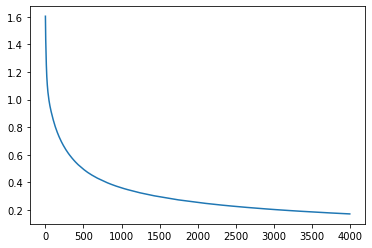

In [0]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [0]:
inference_net.save("inference_net.h5")
generative_net.save("generative_net.h5")

In [0]:
@tf.function
def reconstituate_line_tf(inference_net, generative_net, global_input_output, decoder_input):
    latent_space = inference_net(global_input_output)
    mean, log_var = tf.split(latent_space, 2, axis=-1)
    var = K.exp(log_var)
    batch_size = K.int_shape(mean)[0]
    timesteps = K.int_shape(global_input_output)[1]
    hidden_dim = K.int_shape(mean)[-1]
    eps = K.random_normal(shape=(batch_size,hidden_dim))
    z = mean + eps*var
    sample, _ = generative_net([decoder_input,global_input_output,z])
    return sample


In [13]:
sample = reconstituate_line_tf(inference_net, generative_net, global_input_output, decoder_input)

    def call(self, inputs):
        hidden_layer, y = inputs
        # Get the mask to help us when computing probability density function and losses   
        mask = hidden_layer._keras_mask
        mask = K.cast(mask, tf.float32)        
        y_pos = y[:,:,:2]
        y_eos = y[:,:,2:]
        if self.debugging:
            print("                     ------------------                     ")
            print_tensor(mask, "mask")
            print_tensor(y_pos, "y_pos")
            print_tensor(y_eos, "y_eos")             
        batch_size = (K.shape(hidden_layer)[0],)
        timesteps =  K.int_shape(hidden_layer)[1]
        
        # Computing the weights of the GMM
        mu = K.dot(hidden_layer,self.mu_kernel)
        mu = mu + self.mu_bias      
        
        sigma = K.dot(hidden_layer,self.sigma_kernel)
        sigma = sigma + self.sigma_bias
        sigma = K.exp(sigma)
        
        alpha = K.dot(hidden_layer,self.alpha_kernel)
        alpha = alpha + self.alph

In [0]:
# generative_weights = generative_net.get_weights()
# generative_net.set_weights(generative_weights)

In [0]:
def visualize_reconstruction(coordinates, coordinates_reconstructed, i=None, save=None):
    """ 
    Visualizes stroke3 coordinates
    Args:
        coordinate: list or numpy object of all the sequence of stroke
        characters: list or numpy object  of all characters represented
        i: Int. Index of the character to represent with the sequence of strokes
    """
    fig, ax = plt.subplots(1,2, figsize=(8, 4))
    if i is not None:
        coords_ = coordinates[i]
        coords_pred = coordinates_reconstructed[i]
    else:
        coords_ = coordinates
    ax[0].invert_yaxis()
    ax[1].invert_yaxis()    
    stroke = []
    for x, y, eos in coords_:
        stroke.append((x, y))
        if eos == 1:
            coords = list(zip(*stroke))
            ax[0].plot(coords[0], coords[1], 'k')
            ax[0].set_title("original")                                    
            stroke = []
    for x, y, eos in coords_pred:
        stroke.append((x, y))
        if eos == 1:
            coords = list(zip(*stroke))
            ax[1].plot(coords[0], coords[1], 'k')
            ax[1].set_title("reconstruction")                                    
            stroke = []
    if save is not None:
        fig.savefig("comparison_{}.png".format(i))
        
def offsets_to_coordinates(offsets):
    """
    convert from offsets to coordinates and transform to dtype float if not.
    """
    len_offsets = len(offsets)
    coordinates_list = []
    for i in range(len_offsets):
        coordinates = np.concatenate([np.cumsum(offsets[i][:,:2], axis=0), offsets[i][:,-1:]], axis=1).astype(np.float32)
        coordinates_list.append(coordinates)
    return np.array(coordinates_list)

def toStroke3(arr):
    """ 
    Transform a stroke 5 array to a stroke 3 array. 
    We need to start from the end of the array because of the 
    last condition p3 that encodes when to stop.
    """  
    array = np.copy(arr)
    len_list = len(array)
    for i in range(len_list):
        len_stroke = len(array[i])
        for j in range(len_stroke-1,-1,-1):                                                     
            if (array[i,j,4] == 1. and array[i,j-1,2] == 1.):
                array[i,j,2] = 1.   
            elif array[i,j,4] == 1.:
                array[i,j,2] = 0. 
            elif array[i,j,3] == 1.:
                array[i,j,2] = 1.                   
            else:
                array[i,j,2] = 0.                 
    return array[:,:,:3]  
        
def get_one_hot(tensor):
  new_tensor = np.copy(tensor)
  n_sample = len(tensor)
  for i in range(n_sample):    
    correct_class = np.argmax(new_tensor[i,:,2:], axis=1)
    eos = np.eye(3)[correct_class]
    new_tensor[i,:,2:] = eos
  return new_tensor    


In [0]:
def visualize_prediction(coordinates, coordinates_predicted, i=None, save=None):
    """ 
    Visualizes stroke3 coordinates
    Args:
        coordinate: list or numpy object of all the sequence of stroke
        characters: list or numpy object  of all characters represented
        i: Int. Index of the character to represent with the sequence of strokes
    """
    fig, ax = plt.subplots(1, figsize=(8, 4))
    if i is not None:
        coords_ = coordinates[i]
        coords_pred = coordinates_predicted[i]
    else:
        coords_ = coordinates
    ax.invert_yaxis()       
    stroke = []
    for x, y, eos in coords_:
        stroke.append((x, y))
        if eos == 1:
            coords = list(zip(*stroke))
            ax.plot(coords[0], coords[1], 'k', )                                               
            stroke = []
    for x, y, eos in coords_pred:
        stroke.append((x, y))
        if eos == 1:
            coords = list(zip(*stroke))
            ax.plot(coords[0], coords[1], 'g')          
            stroke = []
    ax.set_title("Black: input data. Green: reconstruction")
    if save is not None:
        fig.savefig("comparison_{}.png".format(i))

In [16]:
strokes = toStroke3(global_input_output)
coords = offsets_to_coordinates(strokes)

new_pred = get_one_hot(sample)
strokes_pred = toStroke3(new_pred)
coords_pred = offsets_to_coordinates(strokes_pred)

NameError: ignored

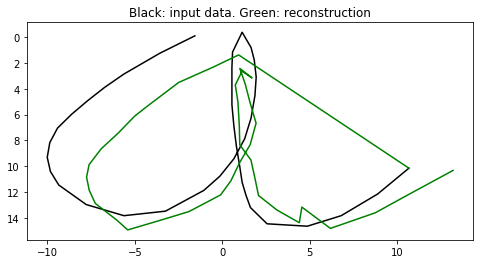

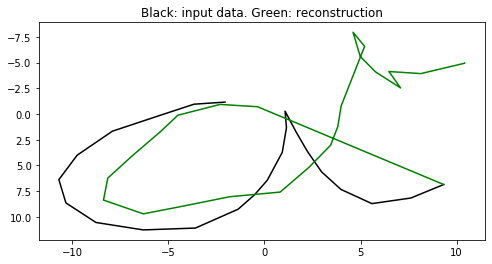

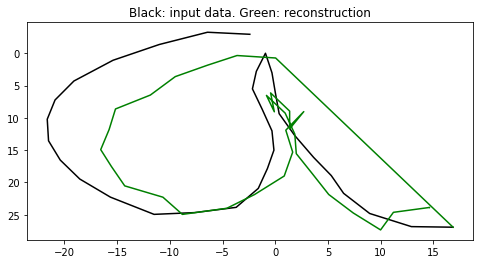

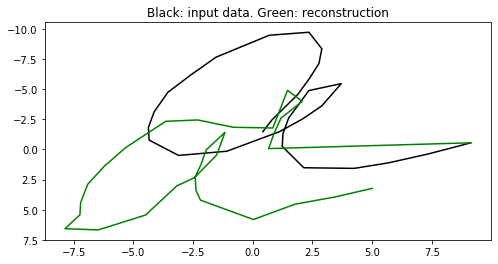

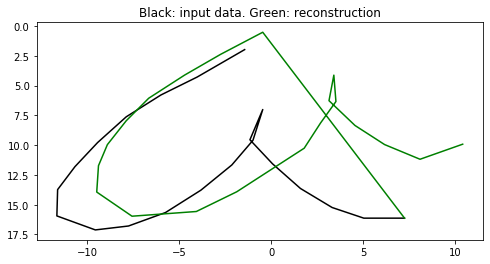

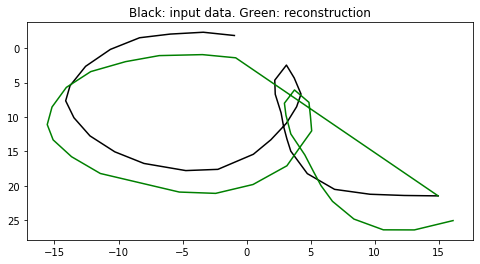

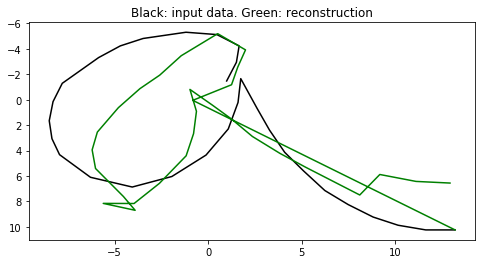

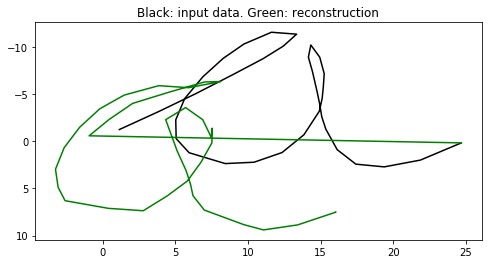

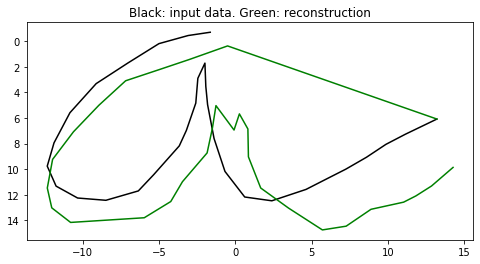

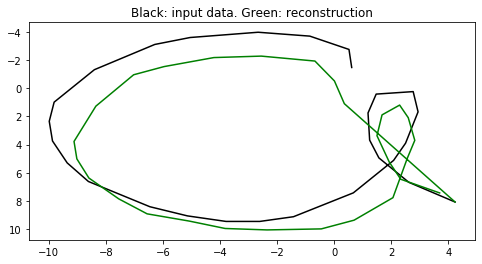

In [17]:
selected_coords = np.random.uniform(0,batch_size,10).astype(np.int16)
for i in selected_coords:
  visualize_prediction(coords, coords_pred, i)

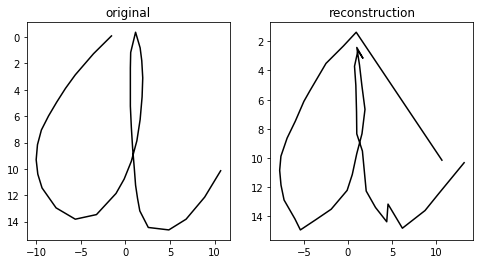

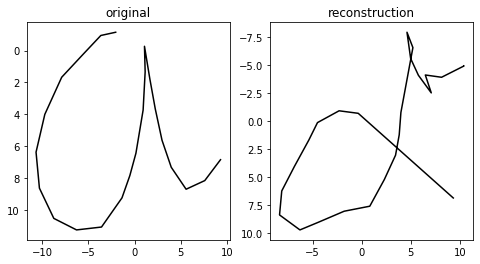

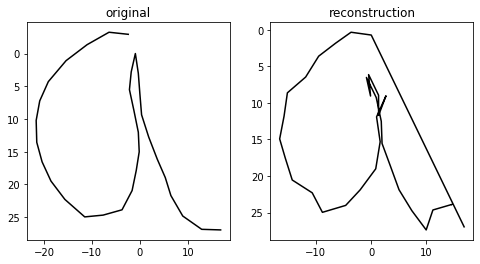

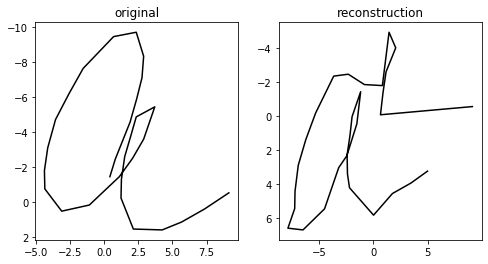

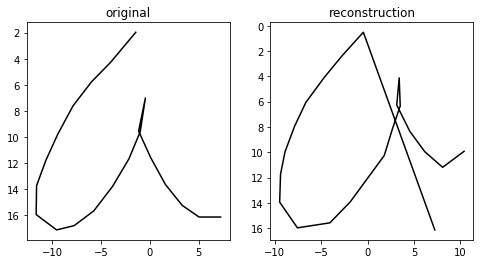

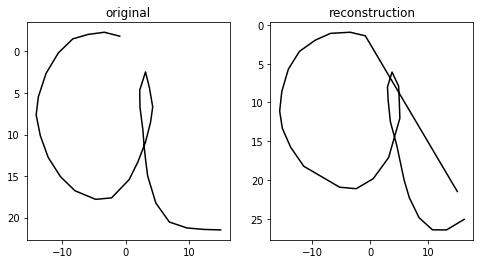

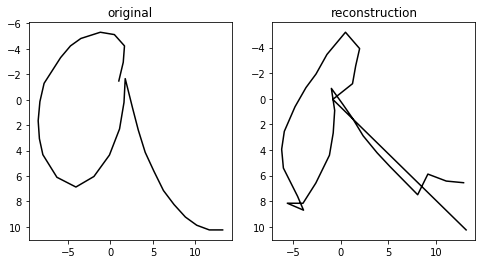

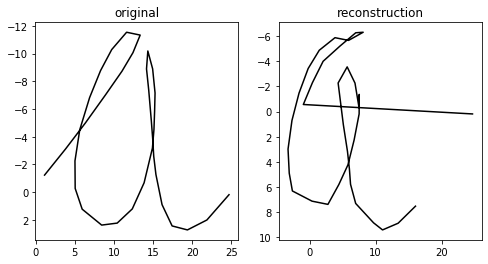

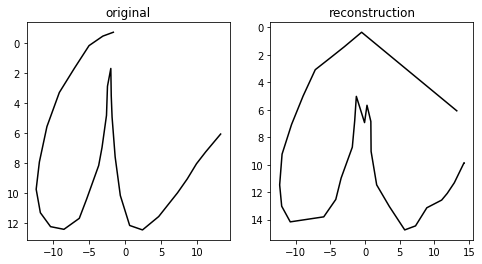

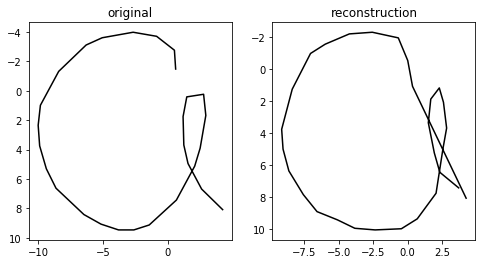

In [18]:
# selected_coords = np.random.uniform(0,120,10).astype(np.int16)
for i in selected_coords:
  visualize_reconstruction(coords, coords_pred, i)

In [0]:
selected_coords = np.random.uniform(0,120,10).astype(np.int16)
for i in range

array([ 38, 106, 114,  72, 104,  27,  95,  21,  95,  83], dtype=int16)

In [0]:
[print("{} {}".format(var[i].name,var[i].shape)) for i in range(len(var))]

dense_1/kernel:0 (32, 32)
dense_1/bias:0 (32,)
gru_1/kernel:0 (37, 96)
gru_1/recurrent_kernel:0 (32, 96)
gru_1/bias:0 (2, 96)
gmm/alpha_kernel:0 (32, 20)
gmm/alpha_bias:0 (1, 20)
gmm/sigma_kernel:0 (32, 40)
gmm/sigma_bias:0 (1, 40)
gmm/mu_kernel:0 (32, 40)
gmm/mu_bias:0 (1, 40)
gmm/end_of_stroke_kernel:0 (32, 3)
gmm/end_of_stroke_bias:0 (1, 3)


[None, None, None, None, None, None, None, None, None, None, None, None, None]

In [0]:
inference_net = load_model("new_inference_net.h5")
generative_net = load_model("new_generative_net.h5", custom_objects={"GMM":GMM})

In [0]:
weight_inference = inference.get_weights()
weight_generative = generative.get_weights()

In [6]:
converter = tf.lite.TFLiteConverter.from_keras_model(inference_net)
tflite_model = converter.convert()

ConverterError: ignored

In [0]:
np.save("inference_w.npy", weight_inference)
np.save("generative_w.npy", weight_generative)

# Recover model from weights only

In [0]:
weight_inference = np.load("inference_w.npy", allow_pickle=True)
weight_generative = np.load("generative_w.npy", allow_pickle=True)


In [0]:
inference_net.set_weights(weight_inference)
generative_net.set_weights(weight_generative)

In [11]:
def reconstituate_line(inference_net, generative_net, global_input_output, decoder_input):
    latent_space = inference_net.predict(global_input_output)
    mean, log_var = np.split(latent_space, 2, axis=-1)
    var = np.exp(log_var)
    batch_size = mean.shape[0]
    hidden_dim = mean.shape[-1]
    eps = np.random.normal(0,1,size=(batch_size,hidden_dim)).astype(np.float32)
    z = mean + eps*var
    # import pdb; pdb.set_trace()
    sample, _ = generative_net([decoder_input,global_input_output,z])
    return sample  

sample2 = reconstituate_line(inference_net, generative_net, global_input_output, decoder_input)


                     ------------------                     
mask :[[0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]]
y_pos :[[[ 0.         -1.2525158 ]
  [-0.60566604 -1.503019  ]
  [-2.4226642   0.09393869]
  ...
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[-2.2839615   0.675338  ]
  [-1.9379066   1.4857436 ]
  [-1.1073753   1.350676  ]
  ...
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[-0.476223   -1.2519691 ]
  [-0.6032158  -1.65583   ]
  [-1.2064316  -1.5750579 ]
  ...
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 ...

 [[ 0.41246378 -1.286091  ]
  [ 0.3830021  -0.87192607]
  [ 1.0606211  -1.8528428 ]
  ...
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[-1.597751   -0.21159467]
  [-1.3929112   0.9874418 ]
  [-

In [56]:
generative_net([decoder_input,global_input_output,z])

    def call(self, inputs):
        hidden_layer, y = inputs
        # Get the mask to help us when computing probability density function and losses   
        mask = hidden_layer._keras_mask
        mask = K.cast(mask, tf.float32)        
        y_pos = y[:,:,:2]
        y_eos = y[:,:,2:]
        if self.debugging:
            print("                     ------------------                     ")
            print_tensor(mask, "mask")
            print_tensor(y_pos, "y_pos")
            print_tensor(y_eos, "y_eos")             
        batch_size = (K.shape(hidden_layer)[0],)
        timesteps =  K.int_shape(hidden_layer)[1]
        
        # Computing the weights of the GMM
        mu = K.dot(hidden_layer,self.mu_kernel)
        mu = mu + self.mu_bias      
        
        sigma = K.dot(hidden_layer,self.sigma_kernel)
        sigma = sigma + self.sigma_bias
        sigma = K.exp(sigma)
        
        alpha = K.dot(hidden_layer,self.alpha_kernel)
        alpha = alpha + self.alph

[<tf.Tensor 'generative_net_5/gmm_1/concatenate_11/concat:0' shape=(120, 221, 5) dtype=float32>,
 <tf.Tensor 'generative_net_5/gmm_1/add_4:0' shape=() dtype=float32>]

In [0]:
strokes = toStroke3(global_input_output)
coords = offsets_to_coordinates(strokes)

new_pred = get_one_hot(sample2)
strokes_pred = toStroke3(new_pred)
coords_pred = offsets_to_coordinates(strokes_pred)

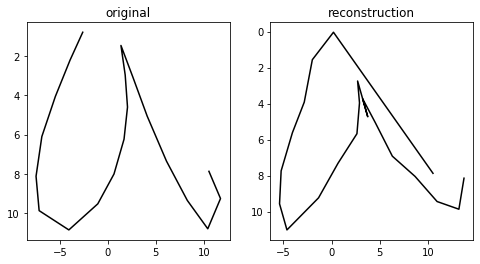

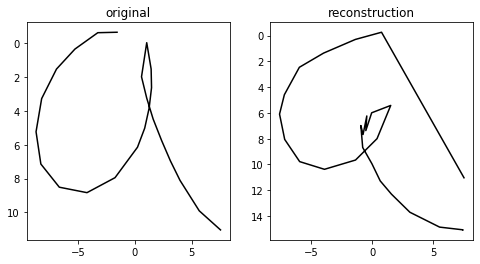

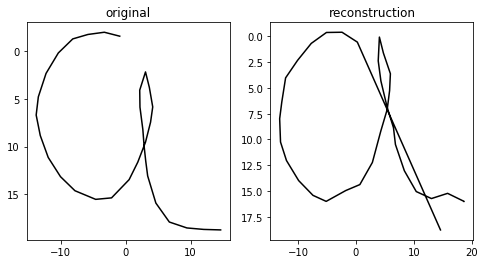

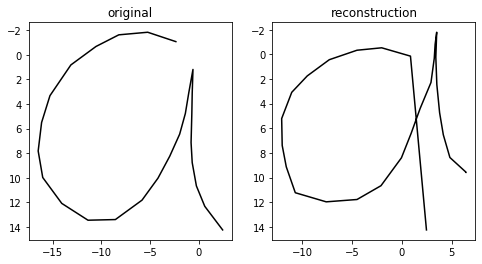

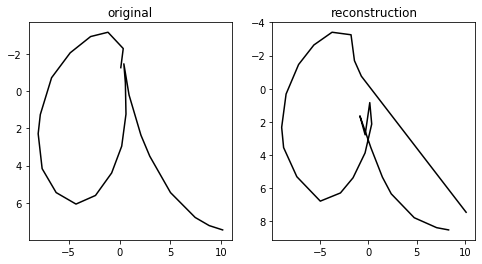

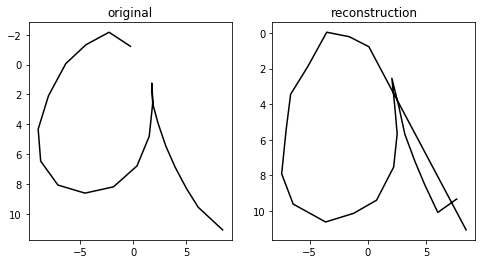

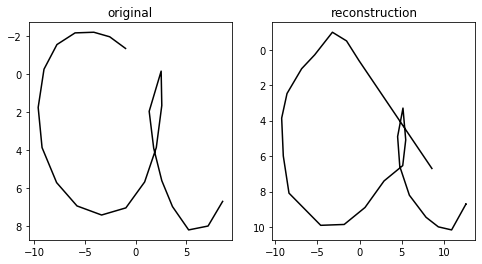

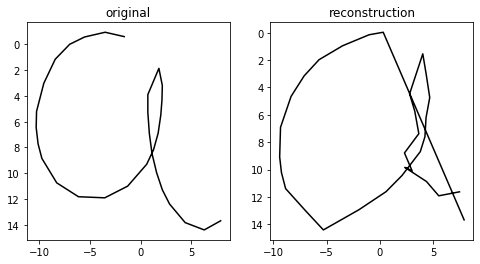

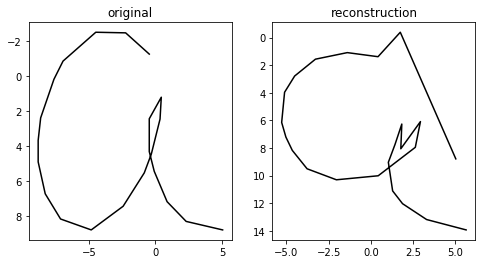

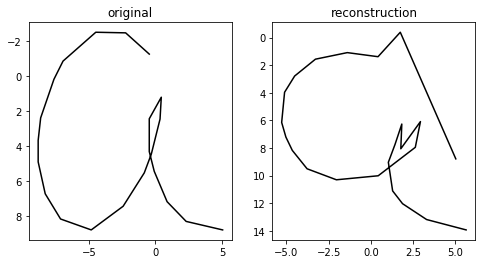

In [18]:
# Selected indices
selected_coords = np.random.uniform(0,batch_size,10).astype(np.int16)

# Visualize with the output of vae
for i in selected_coords:
  visualize_reconstruction(coords, coords_pred, i)
